In [1]:
if 'google.colab' in str(get_ipython()):
    !pip install pytorch_lightning
    !pip install neuralforecast
    
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')

In [160]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

import torch
import pytorch_lightning as pl

import neuralforecast as nf
from neuralforecast.data.datasets.epf import EPF
from pytorch_lightning.callbacks import EarlyStopping
from neuralforecast.data.tsloader import TimeSeriesLoader
from neuralforecast.experiments.utils import create_datasets
from neuralforecast.data.tsdataset import WindowsDataset


# Hyperparameter Definitions

In [3]:
# General Hyperparameters
VAL_PERC = .1
TEST_PERC = .1

In [49]:
# Model Configuration Hyperparameters
mc = {}
mc['model'] = 'n-hits' # Model Name 
mc['mode'] = 'simple' 
mc['activation'] = 'SELU' # Activation function


mc['n_time_in'] = 96 # Length of input sequences
mc['n_time_out'] = 28 # Length of Output Sequences
mc['n_x_hidden'] = 8 # Number of hidden output channels of exogenous_tcn and exogenous_wavenet stacks.
mc['n_s_hidden'] = 0 # Number of encoded static features

mc['stack_types'] = ['identity', 'identity', 'identity'] # List of stack types. Subset from ['seasonality', 'trend', 'identity', 'exogenous', 'exogenous_tcSubset from ['seasonality', 'trend', 'identity', 'exogenous', 'exogenous_tcn', 'exogenous_wavenet'].
mc['constant_n_blocks'] = 1 # Constant n_blocks across stacks
mc['constant_n_layers'] = 2 # Constant n_layers across stacks
mc['constant_n_mlp_units'] = 256 # Constant n_mlp_units across stacks
mc['n_pool_kernel_size'] = [4, 2, 1]  # Pooling size for input for each stack. Note that len(n_pool_kernel_size) = len(stack_types).
mc['n_freq_downsample'] = [24, 12, 1] # Downsample multiplier of output for each stack. Note that len(n_freq_downsample) = len(stack_types).
mc['pooling_mode'] = 'max' # Pooling type. An item from ['average', 'max']
mc['interpolation_mode'] = 'linear' # Interpolation function. An item from ['linear', 'nearest', 'cubic']
mc['shared_weights'] = False # If True, all blocks within each stack will share parameters.

# Optimization and regularization parameters
mc['initialization'] = 'lecun_normal'  #Initialization function. An item from ['orthogonal', 'he_uniform', 'glorot_uniform', 'glorot_normal', 'lecun_normal'].
mc['learning_rate'] = 0.001 # Learning rate between (0, 1).
mc['batch_size'] = 1 # Batch size 
mc['n_windows'] = 32
mc['lr_decay'] = 0.5 # Decreasing multiplier for the learning rate.
mc['lr_decay_step_size'] = 2 # Steps between each learning rate decay.
mc['max_epochs'] = 10 # Maximum number of training epochs
mc['max_steps'] = None # Maximum number of validation epochs
mc['early_stop_patience'] = 20 #Number of consecutive violations of early stopping criteria to end training
mc['eval_freq'] = 500 # How many steps between evaluations
mc['batch_normalization'] = False # Whether perform batch normalization.
mc['dropout_prob_theta'] = 0.0 # Float between (0, 1). Dropout for Nbeats basis.
mc['dropout_prob_exogenous'] = 0.0 # 
mc['weight_decay'] = 0 # L2 penalty for optimizer.
mc['loss_train'] = 'MAE' # Loss to optimize. An item from ['MAPE', 'MASE', 'SMAPE', 'MSE', 'MAE', 'QUANTILE', 'QUANTILE2'].
mc['loss_hypar'] = 0.5 # Hyperparameter for chosen loss.
mc['loss_valid'] = mc['loss_train'] #  Validation loss.  An item from ['MAPE', 'MASE', 'SMAPE', 'RMSE', 'MAE', 'QUANTILE'].
mc['random_seed'] = 1 # random_seed for pseudo random pytorch initializer and numpy random generator.

# Data Parameters
mc['idx_to_sample_freq'] = 1
mc['val_idx_to_sample_freq'] = 1
mc['n_val_weeks'] = 52
mc['normalizer_y'] = None
mc['normalizer_x'] = 'median'
mc['complete_windows'] = False # Consider only full sequences in forecasting horizon
mc['frequency'] = 'h' # Frequency of the data


# Structure of hidden layers for each stack type.
# Each internal list should contain the number of units of each hidden layer.
# Note that len(n_hidden) = len(stack_types).
mc['n_mlp_units'] = len(mc['stack_types']) * [ mc['constant_n_layers'] * [int(mc['constant_n_mlp_units'])] ] 
mc['n_blocks'] =  len(mc['stack_types']) * [ mc['constant_n_blocks'] ] # Number of blocks for each stack. Note that len(n_blocks) = len(stack_types).
mc['n_layers'] =  len(mc['stack_types']) * [ mc['constant_n_layers'] ] # Number of layers for each stack type. Note that len(n_layers) = len(stack_types).

print(65*'=')
print(pd.Series(mc))
print(65*'=')


model                                                   n-hits
mode                                                    simple
activation                                                SELU
n_time_in                                                   96
n_time_out                                                  28
n_x_hidden                                                   8
n_s_hidden                                                   0
stack_types                     [identity, identity, identity]
constant_n_blocks                                            1
constant_n_layers                                            2
constant_n_mlp_units                                       256
n_pool_kernel_size                                   [4, 2, 1]
n_freq_downsample                                  [24, 12, 1]
pooling_mode                                               max
interpolation_mode                                      linear
shared_weights                                         

# Load dataset

In [50]:
first_n=1000
df=pd.read_pickle("m5_aggregate_df.pkl")
df=df.loc[df['id'].isin(df['id'].unique()[0:first_n])]
df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,date,wm_yr_wk,...,cat_sold_avg,dept_sold_avg,cat_dept_sold_avg,store_item_sold_avg,cat_item_sold_avg,dept_item_sold_avg,state_store_sold_avg,state_store_cat_sold_avg,store_cat_dept_sold_avg,rolling_sold_mean
1067150,14370,1437,3,1,0,0,36,0,2011-03-05,11106,...,0.561035,0.695801,0.695801,0.321533,0.216553,0.216553,1.304688,0.801758,1.020508,1.142578
1067151,14380,1438,3,1,0,0,36,0,2011-03-05,11106,...,0.561035,0.695801,0.695801,0.253906,0.259766,0.259766,1.304688,0.801758,1.020508,1.142578
1067152,14390,1439,3,1,0,0,36,0,2011-03-05,11106,...,0.561035,0.695801,0.695801,0.156982,0.076660,0.076660,1.304688,0.801758,1.020508,0.428467
1067153,14400,1440,3,1,0,0,36,0,2011-03-05,11106,...,0.561035,0.695801,0.695801,1.694336,2.011719,2.011719,1.304688,0.801758,1.020508,0.285645
1067154,14410,1441,3,1,0,0,36,0,2011-03-05,11106,...,0.561035,0.695801,0.695801,0.958984,0.755371,0.755371,1.304688,0.801758,1.020508,0.000000


In [51]:
#Static variables
S_df = None

#Training Data
Y_df=df[['id','date','sold']]
Y_df.columns=['unique_id','ds','y']

#Exogenous Variable Training Data
X_df=df[['id','date','sold_lag_2', 'sold_lag_3', 'sold_lag_6', 'sold_lag_12']]
X_df.columns=['unique_id','ds','ex_1','ex_2','ex_3','ex_4']

f_cols = X_df.drop(columns=['unique_id', 'ds']).columns.to_list()

# Data Splitting

In [52]:
n_ds = Y_df["ds"].nunique()
n_val = int(VAL_PERC * n_ds)
n_test = int(TEST_PERC * n_ds)

train_dataset, val_dataset, test_dataset, scaler_y = create_datasets(mc=mc,
                                                                     S_df=None, 
                                                                     Y_df=Y_df, X_df=X_df,
                                                                     f_cols=f_cols,
                                                                     ds_in_val=n_val,
                                                                     ds_in_test=n_test)

/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
INFO:root:Train Validation splits

INFO:root:                    ds           
                   min        max
sample_mask                      
0           2015-05-31 2016-06-19
1           2011-03-05 2015-05-30
INFO:root:
Total data 			1934000 time stamps 
Available percentage=100.0, 	1934000 time stamps 
Insample  percentage=80.04, 	1548000 time stamps

# Defining Dataloader

In [53]:
train_loader = TimeSeriesLoader(dataset=train_dataset,
                                batch_size=int(mc['batch_size']),
                                n_windows=mc['n_windows'],
                                shuffle=True)

val_loader = TimeSeriesLoader(dataset=val_dataset,
                              batch_size=int(mc['batch_size']),
                              shuffle=False)

test_loader = TimeSeriesLoader(dataset=test_dataset,
                               batch_size=int(mc['batch_size']),
                               shuffle=False)

In [54]:
train_loader

# Model Definition

In [55]:
mc['n_x'], mc['n_s'] = train_dataset.get_n_variables()

model = nf.models.nhits.nhits.NHITS(n_time_in=int(mc['n_time_in']),
              n_time_out=int(mc['n_time_out']),
              n_x=mc['n_x'],
              n_s=mc['n_s'],
              n_s_hidden=int(mc['n_s_hidden']),
              n_x_hidden=int(mc['n_x_hidden']),
              shared_weights=mc['shared_weights'],
              initialization=mc['initialization'],
              activation=mc['activation'],
              stack_types=mc['stack_types'],
              n_blocks=mc['n_blocks'],
              n_layers=mc['n_layers'],
              n_mlp_units=mc['n_mlp_units'],
              n_pool_kernel_size=mc['n_pool_kernel_size'],
              n_freq_downsample=mc['n_freq_downsample'],
              pooling_mode=mc['pooling_mode'],
              interpolation_mode=mc['interpolation_mode'],
              batch_normalization = mc['batch_normalization'],
              dropout_prob_theta=mc['dropout_prob_theta'],
              learning_rate=float(mc['learning_rate']),
              lr_decay=float(mc['lr_decay']),
              lr_decay_step_size=float(mc['lr_decay_step_size']),
              weight_decay=mc['weight_decay'],
              loss_train=mc['loss_train'],
              loss_hypar=float(mc['loss_hypar']),
              loss_valid=mc['loss_valid'],
              frequency=mc['frequency'],
              random_seed=int(mc['random_seed']))

# Training and Validation

In [56]:
# Set random seed 
pl.seed_everything(42)

# Define early stopping criteria
early_stopping = EarlyStopping(monitor="val_loss", 
                               min_delta=1e-4, 
                               patience=mc['early_stop_patience'],
                               verbose=True,
                               mode="min")

# Init pytorch lightning trainer
trainer = pl.Trainer(max_epochs=mc['max_epochs'], 
                     gradient_clip_val=1.0,
                     progress_bar_refresh_rate=10, 
                     log_every_n_steps=500, 
                     check_val_every_n_epoch=1,
                     callbacks=[early_stopping])

# Train and Validate Model
trainer.fit(model, train_loader, val_loader)

Global seed set to 42
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:90: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=10)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  rank_zero_deprecation(
GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1584: UserWarning: GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.
  rank_zero_warn(
Set SLURM handle signals.

  | Name  | Type   | Params
---------------------------------
0 | m

Validation sanity check: 0it [00:00, ?it/s]

/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
Global seed set to 42
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. 

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 0.981


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.016 >= min_delta = 0.0001. New best score: 0.965


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.022 >= min_delta = 0.0001. New best score: 0.943


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 0.0001. New best score: 0.935


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0001. New best score: 0.931


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0001. New best score: 0.927


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.926


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.924


# Test

In [57]:
# Obtain Predictions on Test Set
model.return_decomposition = False
outputs = trainer.predict(model, test_loader)

/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/neuralforecast/data/tsloader.py:46: UserWarning: This class wraps the pytorch `DataLoader` with a special collate function. If you want to use yours simply use `DataLoader`. Removing collate_fn
  warnings.warn(
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 1000it [00:00, ?it/s]

In [82]:
len(outputs[0][0])

166

In [74]:
input_list, gt_list = [], []
for d in test_loader:
    Y = d["Y"] 
    inp = Y[:, :mc['n_time_in']]
    input_list.append(inp)

[827, 34, 757, 625, 548, 748, 985, 41, 993, 942]


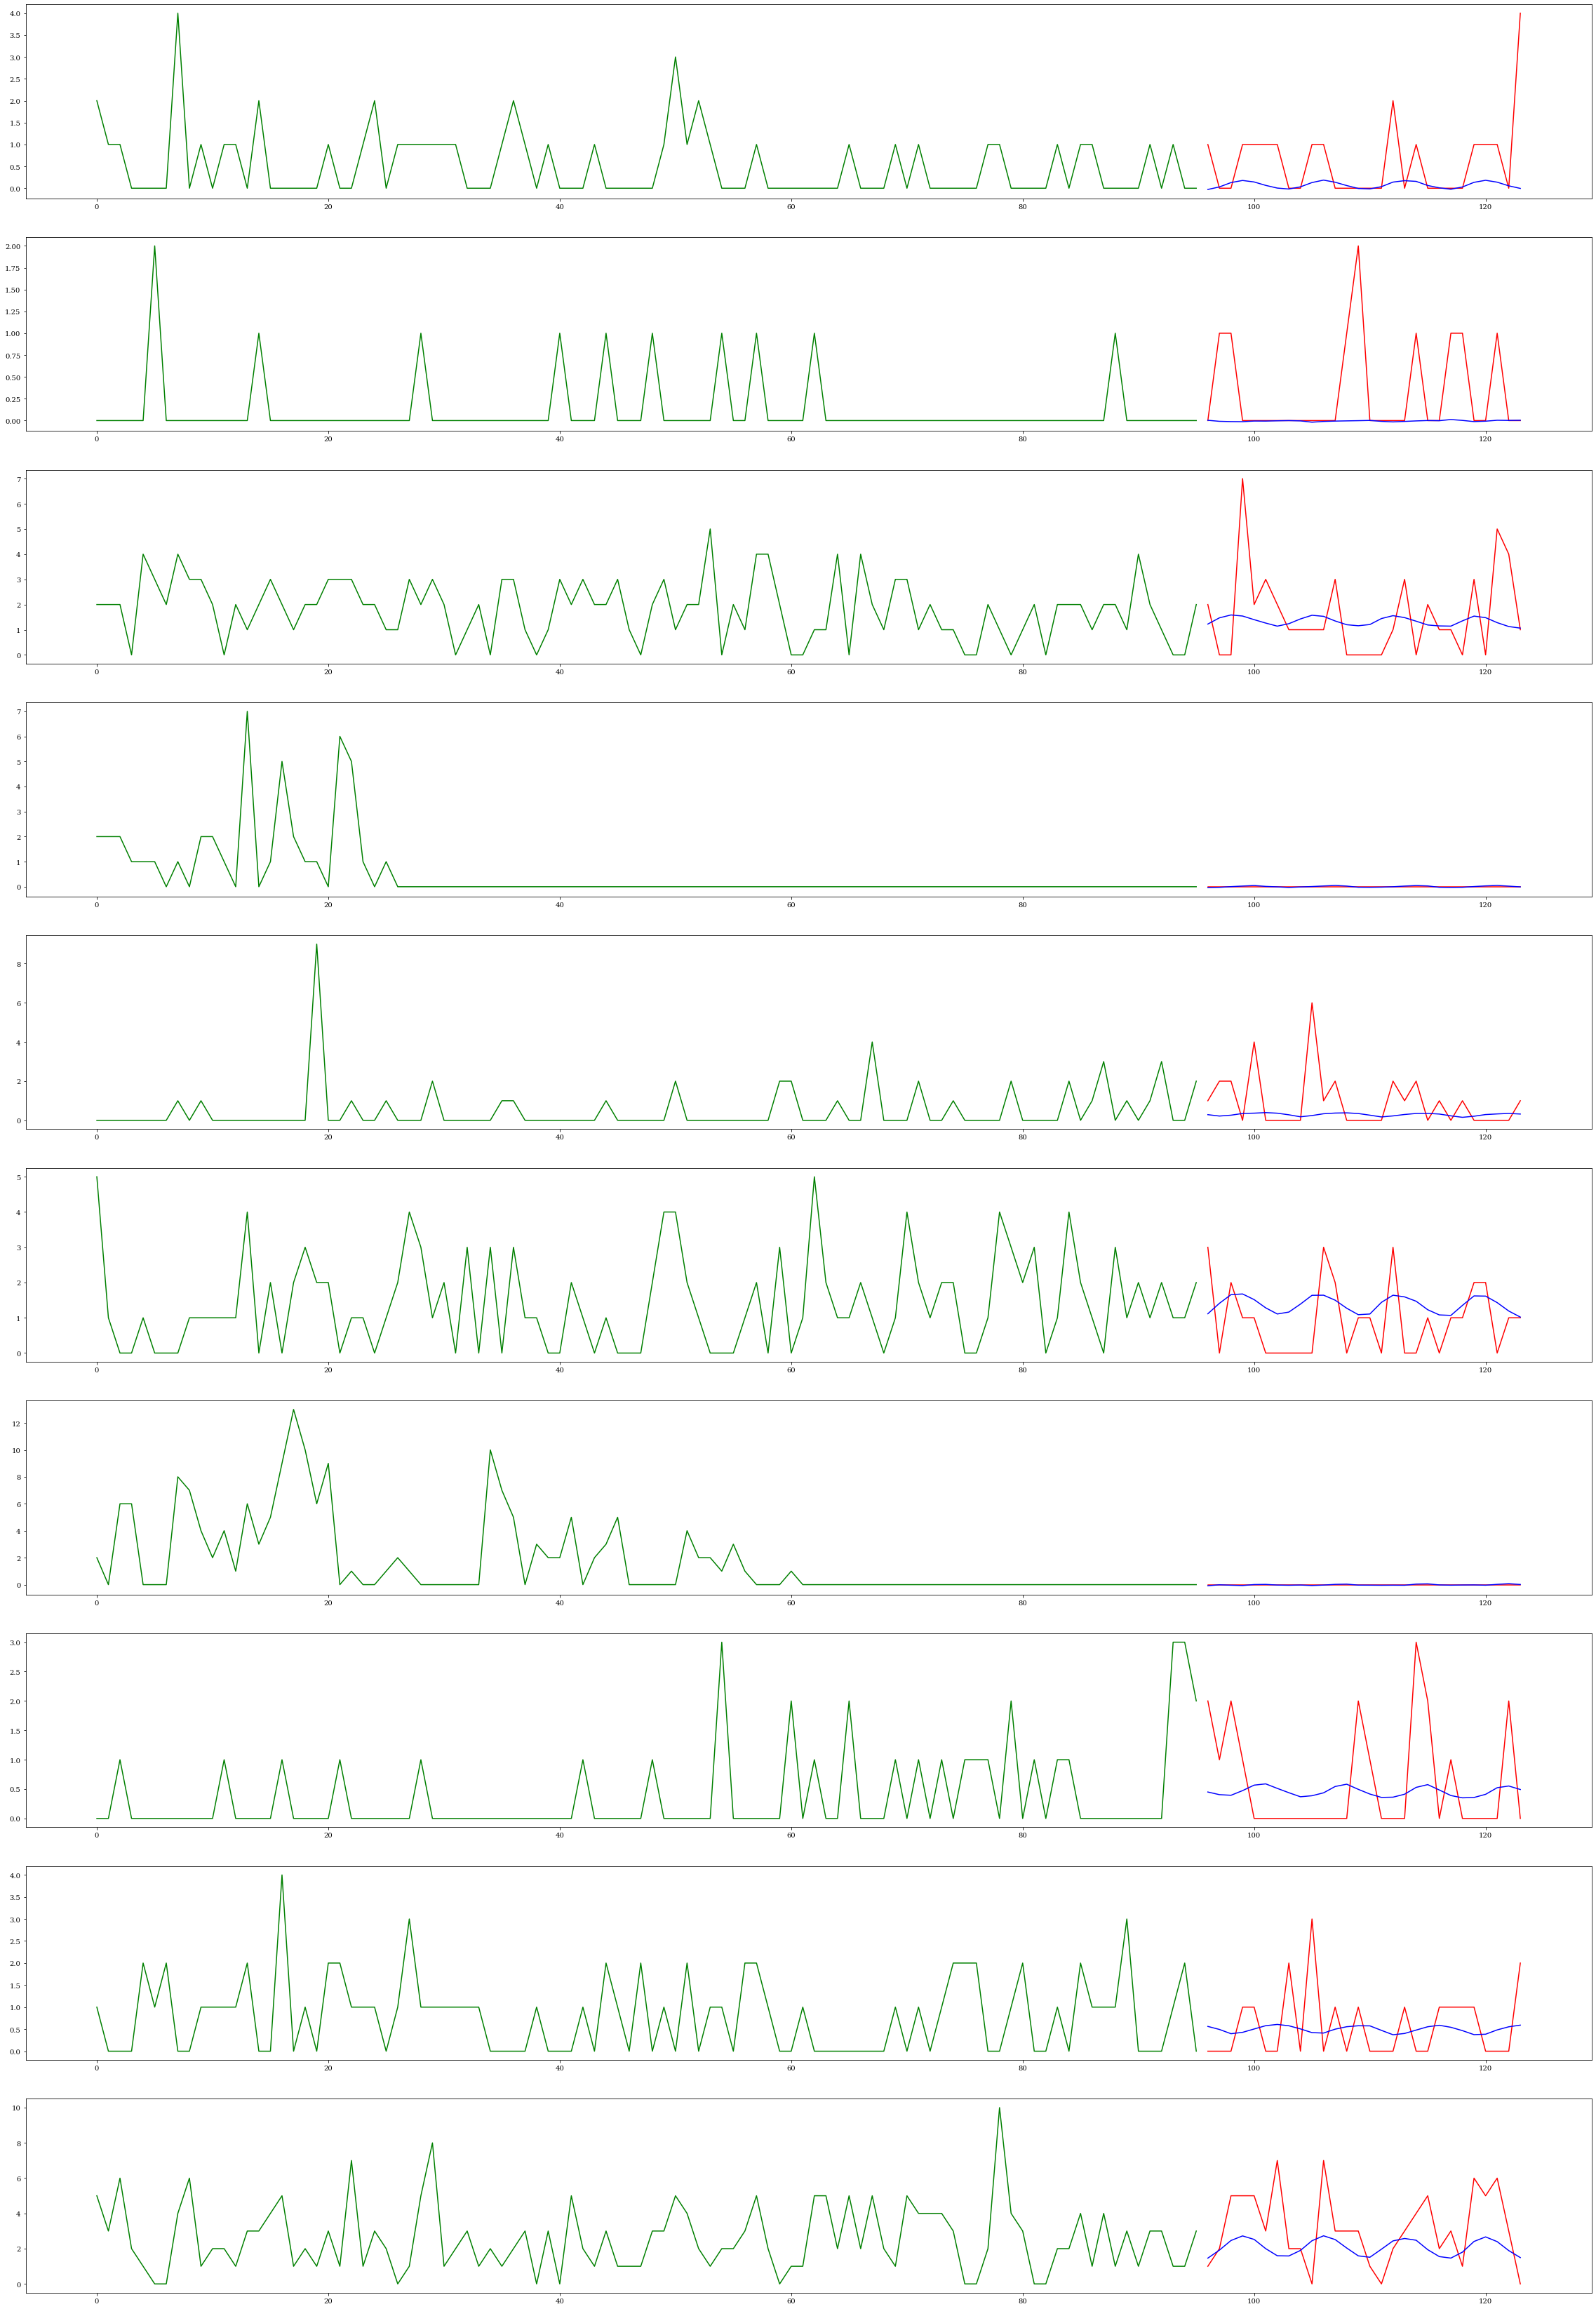

In [99]:
n_samples = 10
ss_indices = np.random.choice((len(outputs)), n_samples, replace=False).tolist()

f, axarr = plt.subplots(n_samples, 1, figsize=(40, 60))

for i, ss_ind in enumerate(ss_indices):
    inp = input_list[ss_ind][0, :].cpu().numpy()

    out1 = outputs[ss_ind][0][0, :].cpu().numpy()
    out2 = outputs[ss_ind][1][0, :].cpu().numpy()


    inp_index = [j for j in range(mc['n_time_in'])]
    out_index = [j for j in range(mc['n_time_in'], mc['n_time_in'] + mc['n_time_out'])]

    
    axarr[i].plot(inp_index, inp, c="green")
    axarr[i].plot(out_index, out1, c="red")
    axarr[i].plot(out_index, out2, c="blue")

In [100]:
# Aggregate list of ground truth and prediction series in to lists
true_list = [output[0] for output in outputs]

pred_list = [output[1] for output in outputs]

# Stack lists into tensors along the sample/batch dimension
trues = torch.concat(true_list, dim=0)
preds = torch.concat(pred_list, dim=0)

# Calculate Losses
mse = mean_squared_error(trues.cpu().numpy(), preds.cpu().numpy())
mae = mean_absolute_error(trues.cpu().numpy(), preds.cpu().numpy())

print(f"MSE: {mse} MAE: {mae}")

MSE: 4.069519519805908 MAE: 0.8771467208862305
